# Simulation

In [59]:
import numpy as np
import pandas as pd
import healpy as hp
from pygsm import GlobalSkyModel

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from power_to_temperature import *
from Tgsm import*

import os
import glob
import copy

#for image storage
impath = "images/"

if not os.path.exists(impath):
    os.makedirs(impath)

## Pre-processing beam pattern data and getting GSM maps.

In [13]:
def hibiscus(pathtbeam = 'HIBiscus/', output = "antenna_beam_biscus/"):
    '''
    DESCRIPTION: Process the beam pattern of the HIBiscus antenna and puts the 
    separated hdf5 files in the "antenna_beam" folder. Each frequency
    has an individual file e.g. "050MHz.hdf5"
    
    INPUT: pathbeam = path of folder with beam pattern .txt files
    '''
    
    Freqs = np.arange(50,91)
    for f in Freqs:
        infile = pathtbeam+"0%dMHz.txt"%f
        Data = np.loadtxt(infile)
        df = pd.DataFrame(data = Data,columns = ['Theta','Phi','dB']) 
        df.to_hdf(output + '0%dMHz.hdf5'%f,'df')
        
def mango_peel(file = "mango_peel_beam_pattern.dat", output = "antenna_beam_mango/"):
    '''
    DESCRIPTION: Process the beam pattern of the Mango Peel or the HIBiscus antenna and puts the 
    separated hdf5 files in the "antenna_beam" folder. Each frequency
    has an individual file e.g. "050MHz.hdf5"
    
    INPUT: file = location of beam pattern .dat file
    '''
    
    df = pd.read_csv(file, sep=", ", 
                 index_col=0, header=None, engine = "python") 
    
    new_header = df.iloc[0] 
    df = df[1:]
    df.columns = new_header
    df.reset_index(inplace=True)
    df.rename(columns = {0:"THETA"}, inplace = True)
    
    theta = list(df["THETA"])
    phi = list(df["'PHI'"])
    
    Freq = np.arange(30000000.0, 150000000.0, 1000000)

    for f in Freq:
        data = df[f]

        file = pd.DataFrame(list(zip(theta, phi, data)), columns =['Theta', 'Phi', 'dB'])

        file["Theta"] = pd.to_numeric(file["Theta"], downcast="float")
        file["Phi"] = pd.to_numeric(file["Phi"], downcast="float")
        file["dB"] = pd.to_numeric(file["dB"], downcast="float")

        name = "0" + str(int(f/(1e+6))) + "MHz"
        file.to_hdf(output+name+'.hdf5','df')

In [14]:
if not os.path.exists('antenna_beam_mango'):
    os.makedirs('antenna_beam_mango')
    mango_peel()

if not os.path.exists('antenna_beam_biscus'):
    os.makedirs('antenna_beam_biscus')
    hibiscus()
    
# Loads the GSM maps files in the folder "gsm_maps"
if not os.path.exists('gsm_maps'):
    os.makedirs('gsm_maps')
        
    Freqs = np.arange(50,91) #Frequency of interest 50-90 MHz.
    for f in Freqs:
        gsm = GlobalSkyModel()
        gsm_map = gsm.generate(f)
        DATA = pd.DataFrame(gsm_map)
        DATA.to_hdf('gsm_maps/gsm_%dMHz.hdf5'%f,'df')

## Generate simulated mock antenna pattern

In [15]:
Freqs = np.arange(50,91)
kB = 1.38064852e-23 #Boltzmann constant

# Inverse transformation from Temp to dBms
#Transformacion de dBm's a potencia
P_dBm = lambda source: 30.+10*np.log10(source)


def T2dBm(T, freqs, Bwidth):
    T = np.array(T, dtype=np.float64)
    
    area = 1.0      # m^2
    angle = 55.0    #degrees
    theta = deg2arcsec(angle)
    freq = freqs * 1e6 #Hz
    wavelength = (c / freq) * 100.  # cm
    
    flux_Jy = T*theta**2/(1.36*wavelength**2.) #mJy
    flux_Jy = flux_Jy / 1e3 # Jy
    flux = flux_Jy / 1e26  # Jy
    power = 0.5*flux*area/Bwidth
    dBm = P_dBm(power)
    return dBm

In [16]:
for antenna in ['mango', 'biscus']:
    
    if not os.path.exists('mock_pattern_'+antenna):
        os.makedirs('mock_pattern_'+antenna)

        for Freq in Freqs:    
            Data = pd.read_hdf('antenna_beam_'+antenna+'/0%dMHz.hdf5'%Freq)

            theta,phi = np.radians(Data.values[:,0]),np.radians(Data.values[:,1])
            X,Y,Z = np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)
            dB = Data.values[:,2]
            Temp = Radio_source_trans(dB,Freq,1e6)
            mock_temp = max(Temp)*np.exp(-0.5*(X/0.3)**2.-0.5*(Y/0.3)**2.)
            mock_dBm = T2dBm(mock_temp,Freq,1e6)
            mock_data = np.transpose([Data.values[:,0],Data.values[:,1],mock_dBm])

            df = pd.DataFrame(data = mock_data,columns = ['Theta','Phi','dB']) 
            df.to_hdf('mock_pattern_'+antenna+'/0%dMHz.hdf5'%Freq,'df')

## Generate simulated data (convolution) 

This part of the notebook generates an HDF5 table with the convolved temperatures of the antenna for a day of observation, the binnage in this case is 5 minutes, it can be changed by modifying the bins parameter.

The function to use is T_gsm from Tgsm.py. 

Uncomment if needed.

In [60]:
# You can change the path to anywhere your antenna beam pattern files are.

#T_gsm('2013-06-14 00:00:00',PATH='mock_pattern_biscus/',OUTPUT='mock_biscus/') 
#T_gsm('2013-06-14 00:00:00',PATH='mock_pattern_mango/',OUTPUT='mock_mango/')

#T_gsm('2013-06-14 00:00:00', PATH = 'antenna_beam_biscus/', OUTPUT = "biscus/") 
#T_gsm('2013-06-14 00:00:00', PATH = 'antenna_beam_mango/', OUTPUT = "mango/")

## Diurnal Variation and Simulated Temperature

Checking the diurnal variation of the temperature for every frequency in the rage 50-90 MHz.

In [18]:
# Data generated in the convolution.
Data_mango = pd.read_hdf('mango/Tgsm.hdf5')
Data_biscus = pd.read_hdf('biscus/Tgsm.hdf5')

Data_mock_mango = pd.read_hdf('mock_mango/Tgsm.hdf5')
Data_mock_biscus = pd.read_hdf('mock_biscus/Tgsm.hdf5')

Freqs = np.arange(50,91)

Checking the Local Sidereal Time (LST) for the date, this is done in order to plot the diurnal variation of a given frequency in functiong of LST, this could be done in function of UTC, but for comparision with SCI-HI paper.

In [19]:
check_LST('2013-06-14 00:00:00')

LST time: 9h36m36.5988s


<Longitude 9.61016633 hourangle>

In [21]:
f=70 #Frequency to check

Temp

array([2.55997020e-05, 4.22410700e+24, 1.20741039e+25, ...,
       1.20741039e+25, 4.22410700e+24, 1.35573532e-05])

In [33]:
Time_

array([ 9.62      ,  9.95802817, 10.29605634, 10.63408451, 10.97211268,
       11.31014085, 11.64816901, 11.98619718, 12.32422535, 12.66225352,
       13.00028169, 13.33830986, 13.67633803, 14.0143662 , 14.35239437,
       14.69042254, 15.0284507 , 15.36647887, 15.70450704, 16.04253521,
       16.38056338, 16.71859155, 17.05661972, 17.39464789, 17.73267606,
       18.07070423, 18.40873239, 18.74676056, 19.08478873, 19.4228169 ,
       19.76084507, 20.09887324, 20.43690141, 20.77492958, 21.11295775,
       21.45098592, 21.78901408, 22.12704225, 22.46507042, 22.80309859,
       23.14112676, 23.47915493, 23.8171831 ,  0.15521127,  0.49323944,
        0.83126761,  1.16929577,  1.50732394,  1.84535211,  2.18338028,
        2.52140845,  2.85943662,  3.19746479,  3.53549296,  3.87352113,
        4.2115493 ,  4.54957746,  4.88760563,  5.2256338 ,  5.56366197,
        5.90169014,  6.23971831,  6.57774648,  6.91577465,  7.25380282,
        7.59183099,  7.92985915,  8.26788732,  8.60591549,  8.94

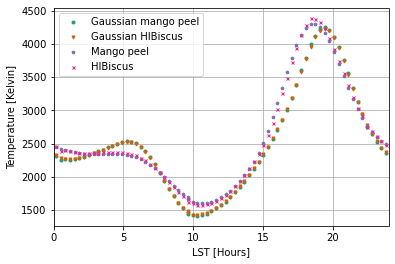

In [56]:
Temp_mango = Data_mango.loc[f].values
Temp_biscus = Data_biscus.loc[f].values
Temp_mock_biscus = Data_mock_biscus.loc[f].values
Temp_mock_mango = Data_mock_mango.loc[f].values

Time_ = (np.linspace(0,24,len(Temp_mango))+9.62)%24 # For 2013-06-14 LST = UTC + 9:37 (9.62h)

plt.plot(Time_,Temp_mock_mango, marker = 'o', linestyle = 'None', markersize = 3, label='Gaussian mango peel', color = '#1b9e77')
plt.plot(Time_,Temp_mock_biscus, marker = 'v', linestyle = 'None', markersize = 3, label='Gaussian HIBiscus', color = '#d95f02')
plt.plot(Time_,Temp_biscus, marker = 'p', linestyle = 'None', markersize = 3, label='Mango peel', color = '#7570b3')
plt.plot(Time_,Temp_mango, marker = 'x', linestyle = 'None', markersize = 3, label='HIBiscus', color = '#e7298a')

plt.xlabel('LST [Hours]')
plt.ylabel('Temperature [Kelvin]')
plt.xlim(0,24)
plt.grid()
plt.legend()
#plt.savefig(impath+'variation_%dMHz.png'%f)

Plotting the diurnal variation for every frequency in the range of 50-90 MHz.

Note: No conversion to LST has be done in this part, so the plot's xlabel is in UTC.

In [51]:
'''

for f in Freqs:
    Temp = Data.loc[f].values
    Time_ = np.linspace(0,24,len(Temp))
    plt.plot(Time_[::5],Temp[::5],'-o',markersize = 4)
    plt.xlabel('UTC [Hours]')
    plt.ylabel('Temperature [Kelvin]')
    plt.xlim(0,24)
    plt.grid()
    plt.savefig('Imagenes/mockvariation_%dMHz.png'%f)
    plt.close()

'''

"\n\nfor f in Freqs:\n    Temp = Data.loc[f].values\n    Time_ = np.linspace(0,24,len(Temp))\n    plt.plot(Time_[::5],Temp[::5],'-o',markersize = 4)\n    plt.xlabel('UTC [Hours]')\n    plt.ylabel('Temperature [Kelvin]')\n    plt.xlim(0,24)\n    plt.grid()\n    plt.savefig('Imagenes/mockvariation_%dMHz.png'%f)\n    plt.close()\n\n"

Plotting the temperature in function of the frequency for the date given.

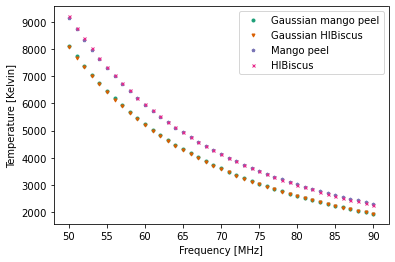

In [58]:
Temp_mango = Data_mango['2013-06-14 08:00:00.000'].values
Temp_biscus = Data_biscus['2013-06-14 08:00:00.000'].values
Temp_mock_mango = Data_mock_mango['2013-06-14 08:00:00.000'].values
Temp_mock_biscus = Data_mock_biscus['2013-06-14 08:00:00.000'].values

plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature [Kelvin]')

plt.plot(Freqs,Temp_mock_mango, marker = 'o', linestyle = 'None',markersize = 3, label='Gaussian mango peel', color = '#1b9e77')
plt.plot(Freqs,Temp_mock_biscus, marker = 'v', linestyle = 'None',markersize = 3, label='Gaussian HIBiscus', color = '#d95f02')
plt.plot(Freqs,Temp_biscus, marker = 'p', linestyle = 'None',markersize = 3, label='Mango peel', color = '#7570b3')
plt.plot(Freqs,Temp_mango, marker = 'x', linestyle = 'None', markersize = 3, label='HIBiscus', color = '#e7298a')

#plt.xlim(60,90)
#plt.ylim(1900,6500)
plt.legend()
#plt.savefig(impath+'FreqvsTemp.png')
plt.show()